<a href="https://colab.research.google.com/github/juliosdutra/ModelagemPPEQ1019/blob/main/meat_deepseek.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# -*- coding: utf-8 -*-
"""
Script para análise da composição de carnes usando espectroscopia NIR e PLSR.

Etapas:
1. Pré-processamento dos espectros (SNV, Z-score, Savitzky-Golay).
2. Divisão dos dados em treino e teste.
3. Treinamento do modelo PLSR com validação cruzada.
4. Avaliação do modelo com métricas (RMSE, R²).
5. Visualização dos resultados e análise de resíduos.
6. Salvamento do modelo treinado.

Dependências: numpy, pandas, matplotlib, scikit-learn, scipy, joblib.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.signal import savgol_filter
from itertools import product
import joblib

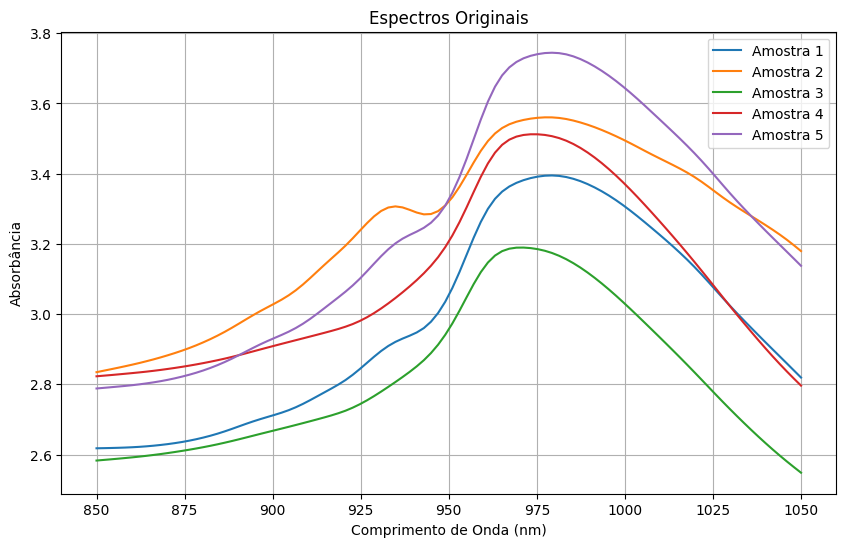

In [10]:
# 🔹 1️⃣ Importar os dados
url = "https://raw.githubusercontent.com/juliosdutra/ModelagemPPEQ1019/main/meats.csv"
df = pd.read_csv(url)

# Separar as features (espectros) e os targets (composição química)
X = df.iloc[:, :-3].values  # Espectros (100 colunas)
y = df.iloc[:, -3:].values  # Teores de água, gordura e proteína

# Visualização dos espectros originais
n, m = X.shape
w = np.linspace(850, 1050, m)

plt.figure(figsize=(10, 6))
for k in range(5):  # Plot das 5 primeiras amostras
    plt.plot(w, X[k, :], label=f"Amostra {k+1}")
plt.title("Espectros Originais")
plt.xlabel("Comprimento de Onda (nm)")
plt.ylabel("Absorbância")
plt.legend()
plt.grid()
plt.show()

In [11]:
# 🔹 2️⃣ Pré-processamento

## SNV (Standard Normal Variate)
def snv(input_data):
    return (input_data - np.mean(input_data, axis=1, keepdims=True)) / np.std(input_data, axis=1, keepdims=True)

X_snv = snv(X)

## Padronização (Z-score)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_snv)

## Suavização e derivadas (Savitzky-Golay)
# Otimização dos parâmetros do Savitzky-Golay
window_lengths = [5, 9, 15, 21]
polyorders = [2, 3, 4]
best_rmse = float('inf')
best_params = {}

for wl, po in product(window_lengths, polyorders):
    X_smooth = savgol_filter(X_scaled, window_length=wl, polyorder=po, deriv=1, axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X_smooth, y, test_size=0.2, random_state=42)
    pls = PLSRegression(n_components=10)  # Número inicial de componentes
    pls.fit(X_train, y_train)
    y_pred = pls.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    if rmse < best_rmse:
        best_rmse = rmse
        best_params = {'window_length': wl, 'polyorder': po}

print(f"Melhores parâmetros Savitzky-Golay: {best_params}, RMSE: {best_rmse:.4f}")

Melhores parâmetros Savitzky-Golay: {'window_length': 5, 'polyorder': 2}, RMSE: 1.6686


In [12]:
# Aplicar os melhores parâmetros
X_smooth = savgol_filter(X_scaled, window_length=best_params['window_length'], polyorder=best_params['polyorder'], deriv=1, axis=1)

# 🔹 3️⃣ Divisão Treino/Teste
X_train, X_test, y_train, y_test = train_test_split(X_smooth, y, test_size=0.2, random_state=42)

# 🔹 4️⃣ Treinamento do modelo PLSR com validação cruzada
param_grid = {'n_components': range(1, 20)}
grid_search = GridSearchCV(PLSRegression(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_n_components = grid_search.best_params_['n_components']
print(f"Melhor número de componentes: {best_n_components}")

pls = PLSRegression(n_components=best_n_components)
pls.fit(X_train, y_train)

# 🔹 5️⃣ Predição e Validação
y_pred = pls.predict(X_test)

## Cálculo das métricas
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

Melhor número de componentes: 13
RMSE: 1.5996
R²: 0.9705


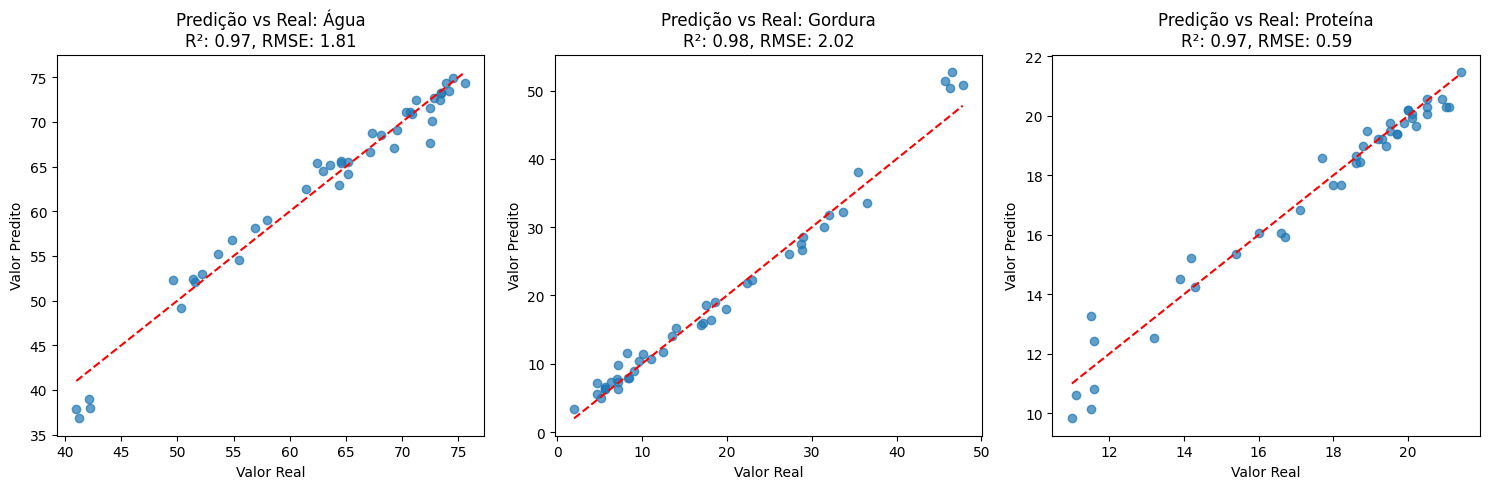

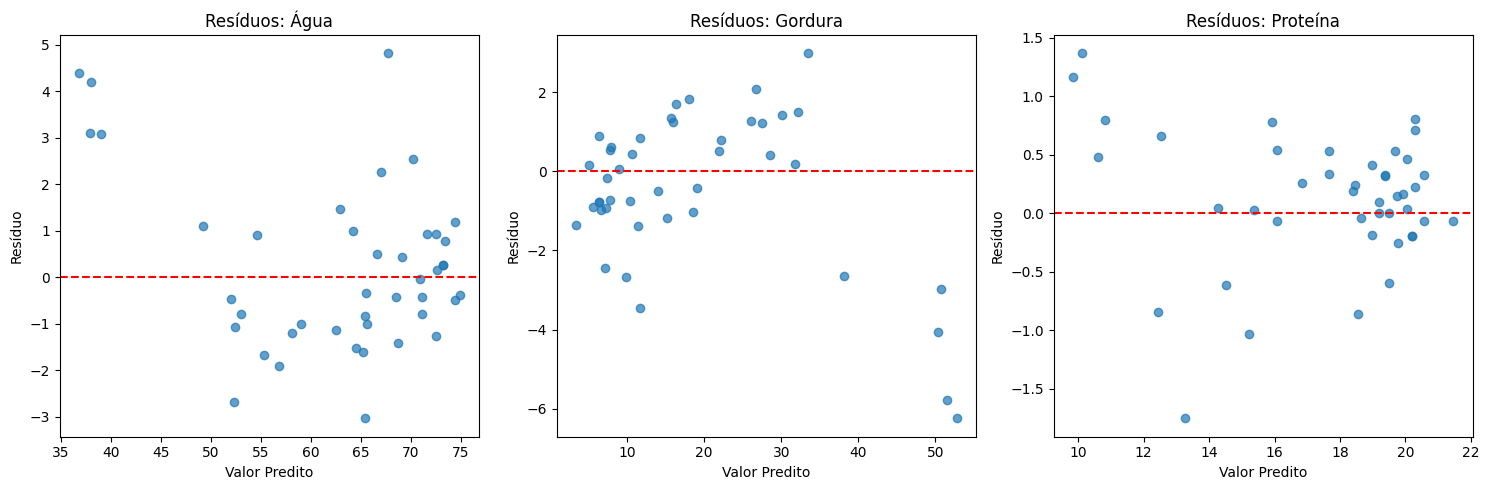

In [13]:
# 🔹 6️⃣ Visualização dos Resultados
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
targets = ["Água", "Gordura", "Proteína"]

for i in range(3):
    axes[i].scatter(y_test[:, i], y_pred[:, i], alpha=0.7)
    axes[i].plot([min(y_test[:, i]), max(y_test[:, i])], [min(y_test[:, i]), max(y_test[:, i])], 'r--')
    axes[i].set_title(f"Predição vs Real: {targets[i]}\nR²: {r2_score(y_test[:, i], y_pred[:, i]):.2f}, RMSE: {np.sqrt(mean_squared_error(y_test[:, i], y_pred[:, i])):.2f}")
    axes[i].set_xlabel("Valor Real")
    axes[i].set_ylabel("Valor Predito")

plt.tight_layout()
plt.show()

# 🔹 7️⃣ Análise de Resíduos
residuals = y_test - y_pred
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i in range(3):
    axes[i].scatter(y_pred[:, i], residuals[:, i], alpha=0.7)
    axes[i].axhline(0, color='red', linestyle='--')
    axes[i].set_title(f"Resíduos: {targets[i]}")
    axes[i].set_xlabel("Valor Predito")
    axes[i].set_ylabel("Resíduo")

plt.tight_layout()
plt.show()

In [14]:
# 🔹 8️⃣ Salvamento do Modelo
joblib.dump(pls, 'pls_model.pkl')
print("Modelo salvo como 'pls_model.pkl'.")

Modelo salvo como 'pls_model.pkl'.


# O que foi Adicionado:
Seleção de Comprimentos de Onda:

Calcula a correlação entre cada comprimento de onda e as variáveis dependentes (água, gordura, proteína).

Seleciona os comprimentos de onda com maior correlação média (neste caso, os 20 melhores).

Reduz a dimensionalidade dos dados, mantendo apenas os comprimentos de onda mais relevantes.

Visualização dos Comprimentos de Onda Selecionados:

Um gráfico de barras mostra os comprimentos de onda selecionados e suas correlações médias.

Benefícios da Seleção de Comprimentos de Onda:
Redução de Dimensionalidade: O modelo fica mais eficiente, pois utiliza apenas os comprimentos de onda mais relevantes.

Melhoria da Interpretação: Fica mais fácil entender quais regiões do espectro são mais importantes para a predição.

Redução de Overfitting: Menos features podem ajudar a evitar overfitting, especialmente em conjuntos de dados pequenos.

In [20]:
# -*- coding: utf-8 -*-
"""
Script para análise da composição de carnes usando espectroscopia NIR e PLSR.

Etapas:
1. Pré-processamento dos espectros (SNV, Z-score, Savitzky-Golay).
2. Seleção de comprimentos de onda com maior correlação.
3. Divisão dos dados em treino e teste.
4. Treinamento do modelo PLSR com validação cruzada.
5. Avaliação do modelo com métricas (RMSE, R²).
6. Visualização dos resultados e análise de resíduos.
7. Salvamento do modelo treinado.

Dependências: numpy, pandas, matplotlib, scikit-learn, scipy, joblib.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.signal import savgol_filter
from itertools import product
import joblib


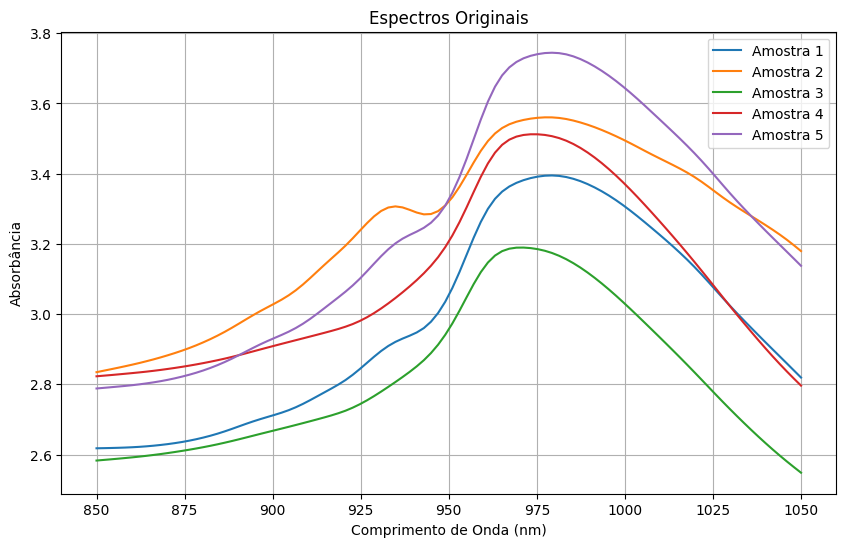

In [21]:
# 🔹 1️⃣ Importar os dados
url = "https://raw.githubusercontent.com/juliosdutra/ModelagemPPEQ1019/main/meats.csv"
df = pd.read_csv(url)

# Separar as features (espectros) e os targets (composição química)
X = df.iloc[:, :-3].values  # Espectros (100 colunas)
y = df.iloc[:, -3:].values  # Teores de água, gordura e proteína

# Visualização dos espectros originais
n, m = X.shape
w = np.linspace(850, 1050, m)

plt.figure(figsize=(10, 6))
for k in range(5):  # Plot das 5 primeiras amostras
    plt.plot(w, X[k, :], label=f"Amostra {k+1}")
plt.title("Espectros Originais")
plt.xlabel("Comprimento de Onda (nm)")
plt.ylabel("Absorbância")
plt.legend()
plt.grid()
plt.show()

In [41]:
# 🔹 2️⃣ Pré-processamento

## SNV (Standard Normal Variate)
def snv(input_data):
    return (input_data - np.mean(input_data, axis=1, keepdims=True)) / np.std(input_data, axis=1, keepdims=True)

X_snv = snv(X)

## Padronização (Z-score)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_snv)

## Suavização e derivadas (Savitzky-Golay)
# Otimização dos parâmetros do Savitzky-Golay
window_lengths = [5, 9, 15, 21]
polyorders = [2, 3, 4]
best_rmse = float('inf')
best_params = {}

for wl, po in product(window_lengths, polyorders):
    X_smooth = savgol_filter(X_scaled, window_length=wl, polyorder=po, deriv=1, axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X_smooth, y, test_size=0.2, random_state=42)
    pls = PLSRegression(n_components=10)  # Número inicial de componentes
    pls.fit(X_train, y_train)
    y_pred = pls.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    if rmse < best_rmse:
        best_rmse = rmse
        best_params = {'window_length': wl, 'polyorder': po}

print(f"Melhores parâmetros Savitzky-Golay: {best_params}, RMSE: {best_rmse:.4f}")

# Aplicar os melhores parâmetros
X_smooth = savgol_filter(X_scaled, window_length=best_params['window_length'], polyorder=best_params['polyorder'], deriv=1, axis=1)

Melhores parâmetros Savitzky-Golay: {'window_length': 5, 'polyorder': 2}, RMSE: 1.6686


**Ótima sugestão!** A seleção de comprimentos de onda mais relevantes pode melhorar a eficiência do modelo, reduzir o overfitting e facilitar a interpretação dos resultados. Vou incluir uma etapa de seleção de comprimentos de onda com base na correlação entre os espectros e as variáveis dependentes (água, gordura, proteína).

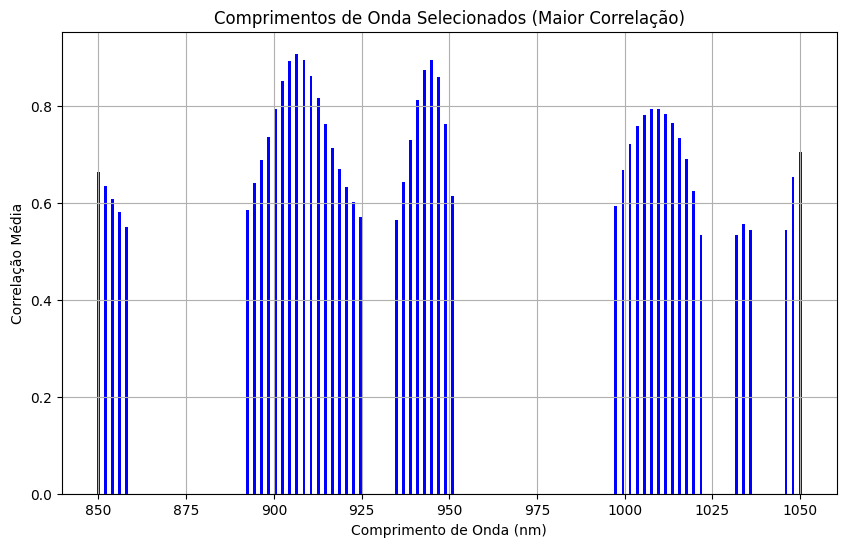

In [42]:
# 🔹 3️⃣ Seleção de comprimentos de onda com maior correlação
# Calcular a correlação entre cada comprimento de onda e as variáveis dependentes
correlations = np.array([np.corrcoef(X_smooth[:, i], y[:, j])[0, 1] for i in range(m) for j in range(3)])
correlations = correlations.reshape(m, 3)  # Formato: (100 comprimentos de onda, 3 variáveis)

# Selecionar os comprimentos de onda com maior correlação média
mean_correlations = np.mean(np.abs(correlations), axis=1)
top_wavelengths = np.argsort(mean_correlations)[-50:]  # Selecionar os 20 melhores
X_selected = X_smooth[:, top_wavelengths]

# Visualização dos comprimentos de onda selecionados
plt.figure(figsize=(10, 6))
plt.bar(w[top_wavelengths], mean_correlations[top_wavelengths], color='blue')
plt.title("Comprimentos de Onda Selecionados (Maior Correlação)")
plt.xlabel("Comprimento de Onda (nm)")
plt.ylabel("Correlação Média")
plt.grid()
plt.show()

In [43]:
# 🔹 4️⃣ Divisão Treino/Teste
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [44]:
# 🔹 5️⃣ Treinamento do modelo PLSR com validação cruzada
param_grid = {'n_components': range(1, 20)}
grid_search = GridSearchCV(PLSRegression(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_n_components = grid_search.best_params_['n_components']
print(f"Melhor número de componentes: {best_n_components}")

pls = PLSRegression(n_components=best_n_components)
pls.fit(X_train, y_train)

# 🔹 6️⃣ Predição e Validação
y_pred = pls.predict(X_test)

## Cálculo das métricas
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

Melhor número de componentes: 15
RMSE: 1.7369
R²: 0.9588


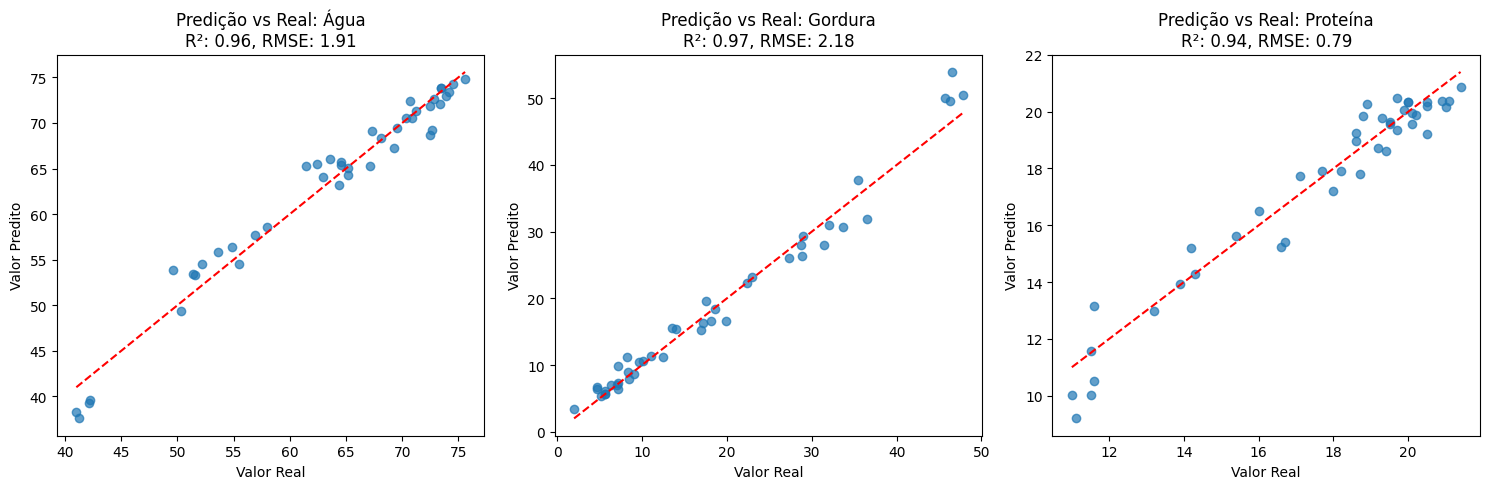

In [45]:
# 🔹 7️⃣ Visualização dos Resultados
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
targets = ["Água", "Gordura", "Proteína"]

for i in range(3):
    axes[i].scatter(y_test[:, i], y_pred[:, i], alpha=0.7)
    axes[i].plot([min(y_test[:, i]), max(y_test[:, i])], [min(y_test[:, i]), max(y_test[:, i])], 'r--')
    axes[i].set_title(f"Predição vs Real: {targets[i]}\nR²: {r2_score(y_test[:, i], y_pred[:, i]):.2f}, RMSE: {np.sqrt(mean_squared_error(y_test[:, i], y_pred[:, i])):.2f}")
    axes[i].set_xlabel("Valor Real")
    axes[i].set_ylabel("Valor Predito")

plt.tight_layout()
plt.show()

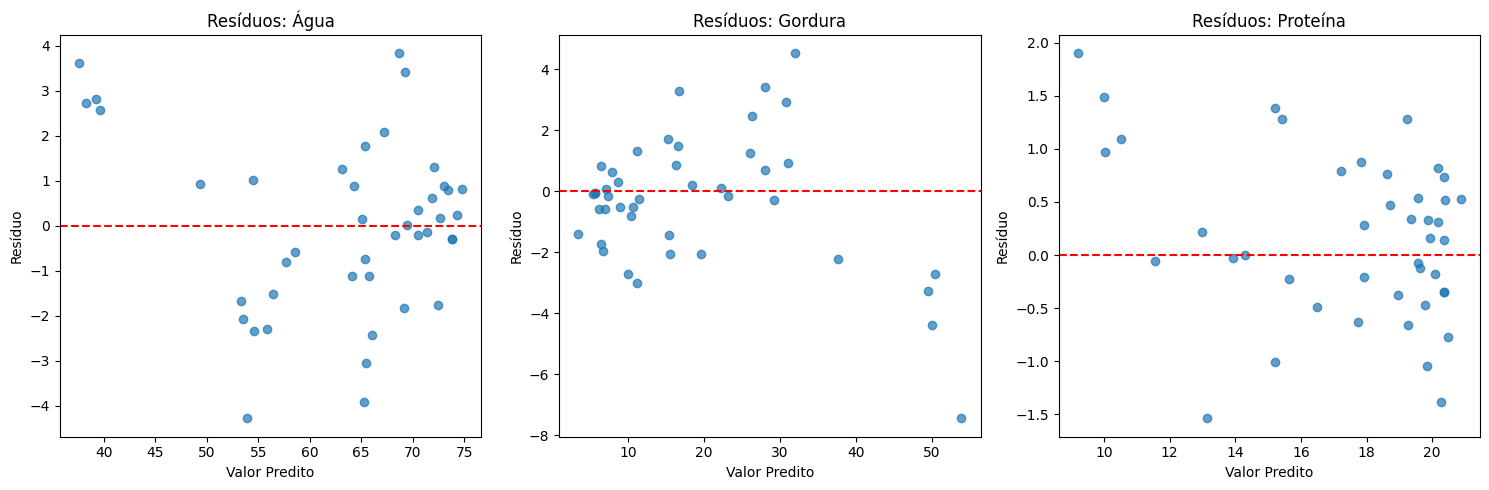

In [46]:
# 🔹 8️⃣ Análise de Resíduos
residuals = y_test - y_pred
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i in range(3):
    axes[i].scatter(y_pred[:, i], residuals[:, i], alpha=0.7)
    axes[i].axhline(0, color='red', linestyle='--')
    axes[i].set_title(f"Resíduos: {targets[i]}")
    axes[i].set_xlabel("Valor Predito")
    axes[i].set_ylabel("Resíduo")

plt.tight_layout();